In [1]:
%cd /Users/aravindhswaminathan/Documents/GitHub/TwoSidedYSYK
#!pwd
import numpy as np
from matplotlib import pyplot as plt
from SYK_fft import *
from ConformalAnalytical import *
import testingscripts
import sys
import pickle

testingscripts.realtimeFFT_validator() # Should return True

/Users/aravindhswaminathan/Documents/GitHub/TwoSidedYSYK


True

In [2]:
g = 0.5
beta = 1000
mu = 0. 
r = 1.
lamb = 1.2/beta
J = 1.2/beta
# lamb = 0.
# J = 0.

M = int(2**22) #number of points in the grid
T = int(2**18) #upper cut-off fot the time
dt = (2*T)/((2*M))
t = dt * (np.arange(2*M) - M)

dw = np.pi/(M*dt)
eta = dw*10.
omega = dw * (np.arange(2*M) - M) 
np.testing.assert_almost_equal(dt*dw*M,np.pi,5, "Error in fundamentals")
err = 1e-1

#delta = 0.420374134464041
np.testing.assert_almost_equal(np.max(np.abs(omega)),np.pi*M/T,5,"Error in creating omega grid")

print("T = ", T, ", dw =  ", f'{dw:.6f}', ", dt = ", f'{dt:.6f}', ', omega_max = ', f'{omega[-1]:.3f}' ) 
print("temp/dw = ", f'{1/(dw*beta):.4f}')

T =  262144 , dw =   0.000012 , dt =  0.062500 , omega_max =  50.265
temp/dw =  83.4430


In [3]:
omegar2 = ret_omegar2(g,beta)
    
def RE_wormhole_YSYK_iterator(GDRomega,GODRomega,DDRomega,DODRomega,g,lamb,J,beta,eta=1e-6,verbose=True):
    
    itern = 0
    diff = 1
    x = 0.5
    diffseries = []
    xGD, xGOD, xDD, xDOD = (0.5,0.5,0.5,0.5)
    diffGD, diffGOD, diffDD, diffDOD = (1.,1.,1.,1.)
    conv_flag = True
    
    while (diff>err and itern<150 and conv_flag): 
        itern += 1 
        diffoldGD,diffoldDD,diffoldGOD,diffoldDOD = (diffGD,diffDD,diffGOD,diffDOD)
        GDRoldomega,DDRoldomega,GODRoldomega,DODRoldomega = (1.0*GDRomega, 1.0*DDRomega, 1.0*GODRomega, 1.0*DODRomega)

        rhoGD = -1.0*np.imag(GDRomega)
        rhoDD = -1.0*np.imag(DDRomega)
        rhoGOD = -1.0*np.imag(GODRomega)
        rhoDOD = -1.0*np.imag(DODRomega)

        SigmaDomega,PiDomega = rhotosigma(rhoGD,rhoDD,M,dt,t,omega,g,beta,kappa=1,delta=eta)
        SigmaODomega,PiODomega = rhotosigma(rhoGOD,rhoDOD,M,dt,t,omega,g,beta,kappa=1,delta=eta)
        ####PiDOmega[M] = -1.0*r - omegar2 - eta**2

        # if itern < 10 : 
        #     PiDomega[M] = -1.0*r - omegar2 - eta**2
        
        detGmat = (omega+1j*eta + mu - SigmaDomega)**2 - (lamb - SigmaODomega)**2
        detDmat = ((omega+1j*eta)**2 - r - PiDomega)**2 - (J - PiODomega)**2
    
        GDRomega = xGD*((omega+1j*eta + mu - SigmaDomega)/detGmat) + (1-xGD)*GDRoldomega
        GODRomega = xGOD*(-1.0*(lamb - SigmaODomega)/detGmat) + (1-xGOD)*GODRoldomega
        DDRomega = xDD*(((omega+1j*eta)**2 - r - PiDomega)/detDmat) + (1-xDD)*DDRoldomega
        DODRomega = xDOD*(-1.0*(J - PiODomega)/detDmat) + (1-xDOD)*DODRoldomega

        if itern > 15 :
            eta=dw*0.01

        diffGD = np. sqrt(np.sum((np.abs(GDRomega-GDRoldomega))**2)) #changed
        diffDD = np. sqrt(np.sum((np.abs(DDRomega-DDRoldomega))**2))
        diffGOD = np. sqrt(np.sum((np.abs(GODRomega-GODRoldomega))**2)) 
        diffDOD = np. sqrt(np.sum((np.abs(DODRomega-DODRoldomega))**2))

        diff = 0.25*(diffGD+diffDD+diffGOD+diffDOD)
        diffGD,diffDD,diffGOD,diffDOD = diff,diff,diff,diff
        diffseries += [diff]

        if diffGD>diffoldGD:
            xGD/=2.
        if diffGOD>diffoldGOD:
            xGOD/=2.
        if diffDD>diffoldDD:
            xDD/=2.
        if diffDOD>diffoldDOD:
            xDOD/=2.
        if verbose:
            print("itern = ",itern, " , diff = ", diffGD, diffDOD, " , x = ", xGOD, xDD, end = '\r')
        if itern>30:
            conv_flag = testingscripts.diff_checker(diffseries, tol = 1e-4, periods = 5)
            

    return (GDRomega,GODRomega,DDRomega,DODRomega)



    

In [4]:
GDRomega = 1/(omega + 1j*eta + mu)
GODRomega = np.zeros_like(omega)
DDRomega = -1/(-1.0*(omega + 1j*eta)**2 + r) 
DODRomega = np.zeros_like(omega)


GDRomega,GODRomega,DDRomega,DODRomega = RE_wormhole_YSYK_iterator(GDRomega,GODRomega,DDRomega,DODRomega,g,lamb,J,beta,eta=1e-6,verbose=True)

GDRt = (0.5/np.pi) * freq2time(GDRomega,M,dt)
DDRt = (0.5/np.pi) * freq2time(DDRomega,M,dt)
GODRt = (0.5/np.pi) * freq2time(GODRomega,M,dt)
DODRt = (0.5/np.pi) * freq2time(DODRomega,M,dt)
# GDRt = (0.5/np.pi) * freq2time(GDRomega - GfreeRealomega(omega,mu,eta),M,dt) + GfreeRealt(t,mu,eta)
# DDRt = (0.5/np.pi) * freq2time(DDRomega - DfreeRealomega(omega,r,eta),M,dt) + DfreeRealt(t,r,eta)
# GODRt = (0.5/np.pi) * freq2time(GODRomega - GfreeRealomega(omega,mu,eta),M,dt) + GfreeRealt(t,mu,eta)
# DODRt = (0.5/np.pi) * freq2time(DODRomega - DfreeRealomega(omega,r,eta),M,dt) + DfreeRealt(t,r,eta)

/Users/aravindhswaminathan/Documents/GitHub/TwoSidedYSYK/SYK_fft.py:87: RuntimeWarning: overflow encountered in exp
  return (1.0/(1.0 + np.exp(arg)))
/Users/aravindhswaminathan/Documents/GitHub/TwoSidedYSYK/SYK_fft.py:102: RuntimeWarning: overflow encountered in exp
  return (1.0/(np.exp(arg)-1))


/Users/aravindhswaminathan/Documents/GitHub/TwoSidedYSYK/testingscripts.py:34: UserWarning: converging too slowly in function RE_wormhole_YSYK_iterator
  warnings.warn('converging too slowly in function ' + inspect.stack()[1][3])


/Users/aravindhswaminathan/anaconda3/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/aravindhswaminathan/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


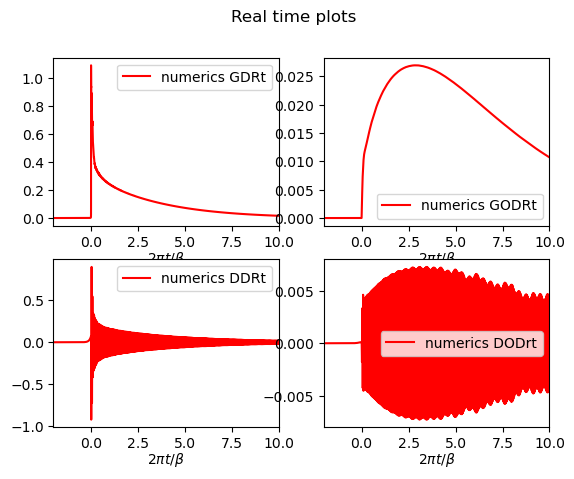

In [5]:
fig, ax = plt.subplots(2,2)
fig.suptitle('Real time plots')

ax[0,0].plot(2*np.pi*t/beta, np.abs(GDRt), 'r', label = 'numerics GDRt')
#ax[0,0].plot(tau/beta, np.abs(GDconftau), 'b--', label = 'analytical GDtau' )
#ax[0,0].set_ylim(0,1)
ax[0,0].set_xlim(-2,10)
ax[0,0].set_xlabel(r'$2\pi t/\beta$',labelpad = 0)
ax[0,0].legend()

ax[0,1].plot(2*np.pi*t/beta, np.abs(GODRt), 'r', label = 'numerics GODRt')
#ax[0,1].set_ylim(0,1)
ax[0,1].set_xlim(-2,10)
ax[0,1].set_xlabel(r'$2\pi t/\beta$',labelpad = 0)
ax[0,1].legend()

ax[1,0].plot(2*np.pi*t/beta, np.real(DDRt), 'r', label = 'numerics DDRt')
#ax[1,0].plot(tau/beta, np.abs(DDconftau), 'b--', label = 'analytical DDtau' )
#ax[1,0].set_ylim(0,1)
ax[1,0].set_xlim(-2,10)
ax[1,0].set_xlabel(r'$2\pi t/\beta$',labelpad = 0)
ax[1,0].legend()

ax[1,1].plot(2*np.pi*t/beta, np.real(DODRt), 'r', label = 'numerics DODrt')
#ax[1,1].set_ylim(0,1)
ax[1,1].set_xlim(-2,10)
ax[1,1].set_xlabel(r'$2\pi t/\beta$',labelpad = 0)
ax[1,1].legend()


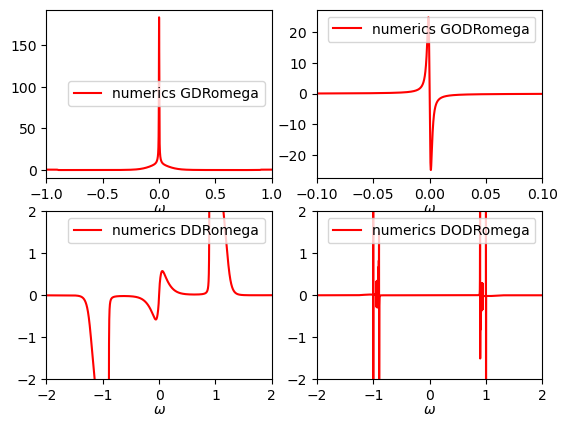

In [6]:
fig, ax = plt.subplots(2,2)

ax[0,0].plot(omega, -np.imag(GDRomega), 'r', label = 'numerics GDRomega')
#ax[0,0].plot(tau/beta, np.abs(GDconftau), 'b--', label = 'analytical GDtau' )
#ax[0,0].set_ylim(0,1)
ax[0,0].set_xlim(-1,1)
ax[0,0].set_xlabel(r'$\omega$',labelpad = 0)
ax[0,0].legend()

ax[0,1].plot(omega, -np.imag(GODRomega), 'r', label = 'numerics GODRomega')
#ax[0,1].set_ylim(0,1)
ax[0,1].set_xlim(-0.1,0.1)
ax[0,1].set_xlabel(r'$\omega$',labelpad = 0)
ax[0,1].legend()

ax[1,0].plot(omega, -np.imag(DDRomega), 'r', label = 'numerics DDRomega')
#ax[1,0].plot(tau/beta, np.abs(DDconftau), 'b--', label = 'analytical DDtau' )
ax[1,0].set_ylim(-2,2)
ax[1,0].set_xlim(-2,2)
ax[1,0].set_xlabel(r'$\omega$',labelpad = 0)
ax[1,0].legend()

ax[1,1].plot(omega, -np.imag(DODRomega), 'r', label = 'numerics DODRomega')
ax[1,1].set_ylim(-2,2)
ax[1,1].set_xlim(-2,2)
ax[1,1].set_xlabel(r'$\omega$',labelpad = 0)
ax[1,1].legend()


(0.0, 100.0)

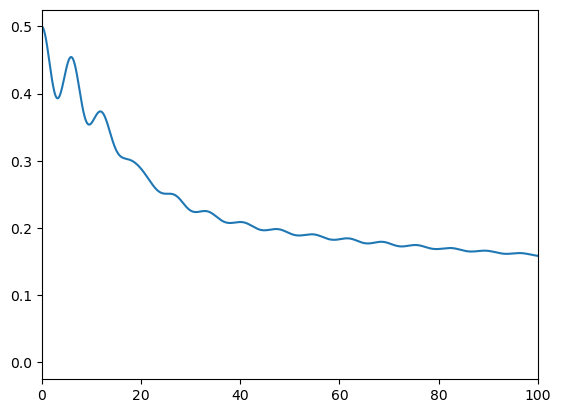

In [7]:
TLL = (0.5/np.pi)*freq2time(-1j*(1-fermidirac(beta*omega))*(-np.imag(GDRomega)),M,dt)
TLL = 2*np.abs(TLL)
plt.plot(t,TLL)
plt.xlim(0,100)